In [1]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
from jax import grad
import jax.numpy as jnp

plt.rcParams.update({'font.size': 22})

## plot field w/ yaw

In [24]:
# [1] Doekemeijer, van der Hoek, van Wingerden, Closed-loop model-based wind farm control
# using FLORIS under time-varying inflow conditions, 2020, Renewable Energy

rho = 1.225 # density of air
D = 178.3  # radius of wind turbine blades; from [1]
A = np.pi*(D/2)**2 # swept area of wind turbine blades
p = 2. # power on yaw angle in power eqn. TO DO: look up real value
a = .2 # max is Betz limit=1/3; Bastankhah has values a=.1 to .33
Cp = 4.*a*(1.-a)**2 
Ct = 4*a*(1-a) # Bastankhah has values .4 to .9 -> a=.1 to .33 (wake deflection larger for larger Ct)

U_inf = 8. # [1]

ky = .05 # [1] wake expansion = .02 in Bastankhah

C0 = 1. - np.sqrt(1-Ct)
M0 = C0*(2.-C0)
E0 = C0**2 - 3.*np.exp(1./12.)*C0+3.*np.exp(1./3.)

In [26]:
def get_u(x,y, gamma, x0, y0):
    sigma_z0 = np.sqrt(1./8.)*D 
    sigma_y0 = sigma_z0*np.cos(gamma)

    theta = .3*gamma/np.cos(gamma)*(1-np.sqrt(1-Ct*np.cos(gamma)))
    delta0 = (x-x0)*theta # Annoni wrong -> see Bastankhah (7.4)
    sigma_y = ky*(x-x0)+sigma_y0
    delta_log = np.log(((1.6+np.sqrt(M0))*(1.6*np.sqrt(sigma_y/sigma_y0)-np.sqrt(M0))) / 
                       ((1.6-np.sqrt(M0))*(1.6*np.sqrt(sigma_y/sigma_y0)+np.sqrt(M0))))
    delta = y0 + delta0 + D*theta*E0/5.2*np.sqrt(sigma_y0/(ky*M0))*delta_log

    C = 1. - np.sqrt(1. - sigma_y0*M0/sigma_y)
    
    return U_inf*(1.-C*np.exp(-.5*((y-delta)/sigma_y)**2))

In [44]:
N = 1000
y_min = -3.*D
y_max = 3.*D
y = np.linspace(y_min, y_max, N)

y0s = [1.*D, -1.*D]
Us_row1 = []
Us_row2 = []

In [48]:
# row 1
x0 = -1.*D # [1] 1.088
x_min = x0+1.*D
x_max = 12*D
x = np.linspace(x_min, x_max, N)
X, Y = np.meshgrid(x, y)
    
for y0 in y0s:
    Us = []
    # gammas = np.pi/180.*np.array([0., 10., 20., gammaStar*180./np.pi, 30.])
    gammas = np.pi/180.*np.array([0., 10., 20., 30.])
    for gamma in gammas:
        U = np.zeros((N,N))
        for i in range(N):
            xi = x[i]
            U[i,:] = get_u(xi, y, gamma, x0, y0)
        Us.append(U)
    Us_row1.append(Us)

#     for i in range(len(Us)):
#         U = Us[i]
#         gamma = gammas[i]*180./np.pi
#         plt.rcParams["figure.figsize"] = (25,5)
#         plt.rcParams.update({'font.size': 22})

#         plt.imshow(U.T/U_inf, extent=[x_min/D, x_max/D, y_max/D, y_min/D], cmap='jet')
#         ax=plt.gca()
#         ax.invert_yaxis()
#         plt.xlabel(r'$x/D$')
#         plt.ylabel(r'$y/D$')
#         cbar = plt.colorbar()
#         cbar.set_label(r'$u/U_{\infty}$')
#         plt.title(r'$u(x,y)$ with $\gamma=%d^{\circ}$'%np.round(gamma))
#         #plt.savefig('flowField_turbine1_gamma%d'%np.round(gamma), bbox_inches='tight')
#         plt.show()

In [49]:
# row 2
x0 = 5.*D
x_min = x0+1.*D
x_max = 12*D
x = np.linspace(x_min, x_max, int(N/2))
X, Y = np.meshgrid(x, y)
    
for y0 in y0s:
    Us = []
    
    # no yaw for last row, which is row 2 rn
    # gammas = np.pi/180.*np.array([0., 10., 20., gammaStar*180./np.pi, 30.])
    #gammas = np.pi/180.*np.array([0., 10., 20., 30.])
    gammas = np.pi/180.*np.array([0.])
    for gamma in gammas:
        U = np.zeros((int(N/2),N))
        for i in range(int(N/2)):
            xi = x[i]
            U[i,:] = get_u(xi, y, gamma, x0, y0)
        Us.append(U)
    Us_row2.append(Us)

#     for i in range(len(Us)):
#         U = Us[i]
#         gamma = gammas[i]*180./np.pi
#         plt.rcParams["figure.figsize"] = (25,5)
#         plt.rcParams.update({'font.size': 22})

#         plt.imshow(U.T/U_inf, extent=[x_min/D, x_max/D, y_max/D, y_min/D], cmap='jet')
#         ax=plt.gca()
#         ax.invert_yaxis()
#         plt.xlabel(r'$x/D$')
#         plt.ylabel(r'$y/D$')
#         cbar = plt.colorbar()
#         cbar.set_label(r'$u/U_{\infty}$')
#         plt.title(r'$u(x,y)$ with $\gamma=%d^{\circ}$'%np.round(gamma))
#         #plt.savefig('flowField_turbine2_gamma%d'%np.round(gamma), bbox_inches='tight')
#         plt.show()

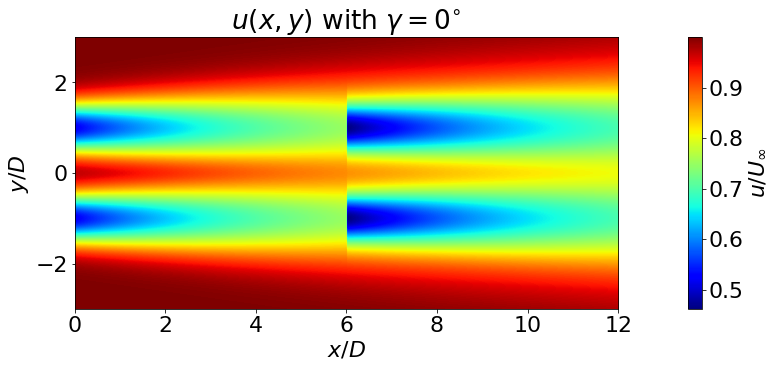

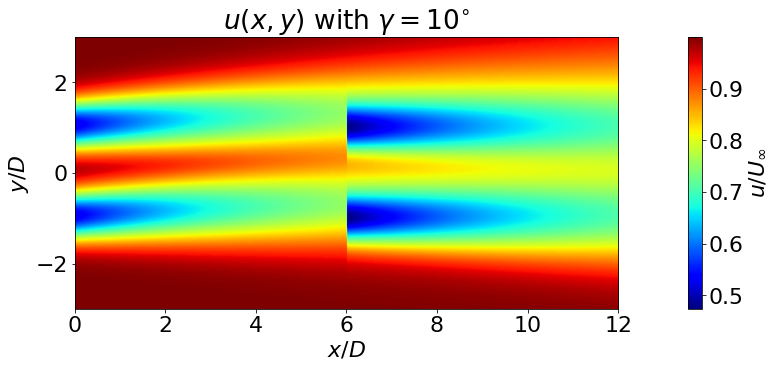

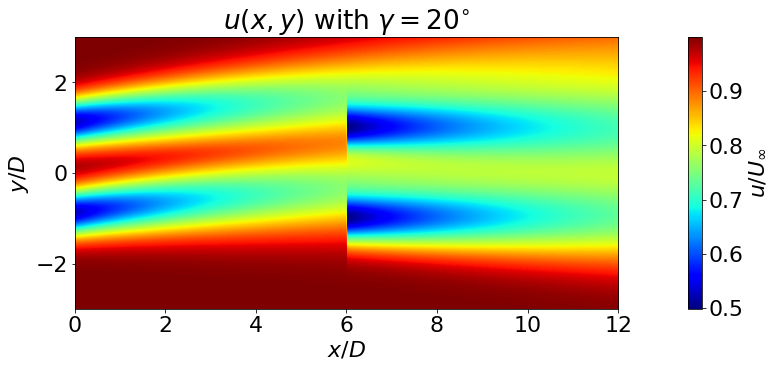

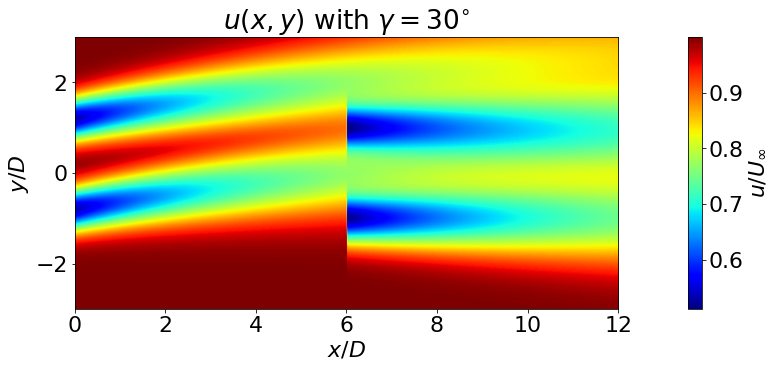

In [54]:
x0 = 0.*D
x_min = x0
x_max = 12*D
x = np.linspace(x_min, x_max, N)
gammas = np.pi/180.*np.array([0., 10., 20., 30.]) # gammas for row 1
N2 = int(N/2)

for i in range(len(gammas)):   
    gamma = gammas[i]*180./np.pi
    

    U_tot = np.zeros((N,N))
    
    for j in range(len(Us_row1)):
        U1 = Us_row1[j][i]
        U2 = Us_row2[j][0] #no yaw for row 2
        
        
        U_tot += (1.-U1/U_inf)**2
        U_tot[N2:,:] += (1.-U2/U_inf)**2
    U_tot = U_inf*(1.-np.sqrt(U_tot))

    plt.rcParams["figure.figsize"] = (25,5)
    plt.rcParams.update({'font.size': 22})

    plt.imshow(U_tot.T/U_inf, extent=[x_min/D, x_max/D, y_max/D, y_min/D], cmap='jet')
    ax=plt.gca()
    ax.invert_yaxis()
    plt.xlabel(r'$x/D$')
    plt.ylabel(r'$y/D$')
    cbar = plt.colorbar()
    cbar.set_label(r'$u/U_{\infty}$')
    plt.title(r'$u(x,y)$ with $\gamma=%d^{\circ}$'%np.round(gamma))
    plt.savefig('flowField_fourTurbines_gamma%d'%np.round(gamma), bbox_inches='tight')
    plt.show()

## find optimal yaw angles to maximize total power produced by all turbines in wind farm

In [55]:
# [1] Doekemeijer, van der Hoek, van Wingerden, Closed-loop model-based wind farm control
# using FLORIS under time-varying inflow conditions, 2020, Renewable Energy

rho = 1.225 # density of air
D = 178.3  # radius of wind turbine blades; from [1]
A = np.pi*(D/2)**2 # swept area of wind turbine blades
p = 2. # power on yaw angle in power eqn. TO DO: look up real value
a = .2 # max is Betz limit=1/3; Bastankhah has values a=.1 to .33
Cp = 4.*a*(1.-a)**2 
Ct = 4*a*(1-a) # Bastankhah has values .4 to .9 -> a=.1 to .33 (wake deflection larger for larger Ct)

U_inf = 8. # [1]

ky = .05 # [1] wake expansion = .02 in Bastankhah

C0 = 1. - np.sqrt(1-Ct)
M0 = C0*(2.-C0)
E0 = C0**2 - 3.*np.exp(1./12.)*C0+3.*np.exp(1./3.)

sigma_z0 = np.sqrt(1./8.)*D 

In [84]:
def get_blah(x):
    x1, x2 = x
    return x1+x2
    
x = jnp.array([1., 2.])
# get_blah(x)

dBlah = grad(get_blah)
dBlah(x)

DeviceArray([1., 1.], dtype=float32)

In [422]:
# velocity at downstream turbines (used to calculate power)
us = np.zeros(2)
def get_sigma_y0(gamma):
    return sigma_z0*jnp.cos(gamma)

def get_theta(gamma):
    return .3*gamma*jnp.cos(gamma)*(1-jnp.sqrt(1-Ct*jnp.cos(gamma)))

# x0
def get_delta0(gamma, x0):
    theta = get_theta(gamma)
    return x0*theta

def get_sigma_y(gamma, x0, x):
    sigma_y0 = get_sigma_y0(gamma)
    return ky*(x-x0)+sigma_y0

def get_delta(gamma, x0, y0, x):
    sigma_y = get_sigma_y(gamma, x0, x)
    sigma_y0 = get_sigma_y0(gamma)
    delta_log = jnp.log(((1.6+np.sqrt(M0))*(1.6*jnp.sqrt(sigma_y/sigma_y0)-np.sqrt(M0))) / 
                       ((1.6-np.sqrt(M0))*(1.6*jnp.sqrt(sigma_y/sigma_y0)+np.sqrt(M0))))
    delta0 = get_delta0(gamma, x0)
    theta = get_theta(gamma)
    return y0 + delta0 + D*theta*E0/5.2*jnp.sqrt(sigma_y0/(ky*M0))*delta_log

def get_C(gamma, x0, x):
    sigma_y = get_sigma_y(gamma, x0, x)
    sigma_y0 = get_sigma_y0(gamma)    
    return 1. - jnp.sqrt(1. - sigma_y0*M0/sigma_y)

def get_u(gamma, x0, y0, x, y):
    C = get_C(gamma, x0, x)
    delta = get_delta(gamma, x0, y0, x)
    sigma_y = get_sigma_y(gamma, x0, x)
    return U_inf*(1.-C*jnp.exp(-.5*jnp.power((y-delta)/sigma_y, 2)))

def get_U(gammas, x0s, y0s, xs, ys):
    Us = jnp.zeros(len(xs)) # velocity at downstream turbines to calculate power
    for i in range(len(xs)):
        x = xs[i]
        y = ys[i]

        for j in range(len(x0s)):
            # calculate weight from upstream turbine j
            gamma = gammas[j]
            x0 = x0s[j]
            y0 = y0s[j]
            u = get_u(gamma, x0, y0, x, y) 
            Us = Us.at[i].set(Us[i] + jnp.power(1.-u/U_inf, 2))
        Us = Us.at[i].set(U_inf*(1.-jnp.sqrt(Us[i])))
    return Us

def get_P2(gammas, x0s, y0s, xs, ys):
    Us = get_U(gammas, x0s, y0s, xs, ys)
    gamma2 = 0.
    return jnp.sum(.5*rho*A*Cp*jnp.cos(jnp.power(gamma2,2))*jnp.power(Us,3))

In [427]:
# locations of upstream turbines (cause wake)
gammas = cp.Variable(2) # yaw angle of upstream turbines; optimization variable
x0s = [-1.*D, -1.*D] # [1] 1.088D
y0s = [-1.*D, 2.*D]

# locations  to calculate wake (locations of turbines except first row)
xs = [5.*D, 5.*D]
ys = [-1.*D, 1.*D]

# initial guess for linearization pts
gamma0s = np.array([10.*np.pi/180., 10.*np.pi/180.])

# save linearization pts and optimal gammas
gamma0s_save = []
gammaStars_save = []

for k in range(50):
    # set up and solve problem
    P1 = cp.sum(.5*rho*A*Cp*U_inf**3*
                (np.cos(gamma0s**2) - cp.multiply(np.sin(gamma0s**2), (gammas**2-gamma0s**2))))
    dP2 = grad(get_P2)
    P2 = get_P2(gamma0s, x0s, y0s, xs, ys) + dP2(gamma0s, x0s, y0s, xs, ys) @ (gammas - gamma0s)
    P = P1 + P2
    u_ideal = U_inf
    P_ideal = 4.*np.sum(1./2.*rho*A*Cp*u_ideal**3)
    constraints = [gammas <= 50.*np.pi/180., gammas >= 0.] # constraining to positive yaw common
    prob = cp.Problem(cp.Minimize(P_ideal - P), constraints)
    # P.is_convex(), P.is_concave(), prob.is_dcp()
    prob.solve()
    gammaStars = gammas.value
    gammaStars_save.append(gammaStars.copy())
    gamma0s_save.append(gamma0s.copy())
    gamma0s += .1*(gammaStars - gamma0s)
gamma0s_save = np.array(gamma0s_save)
gammaStars_save = np.array(gammaStars_save)

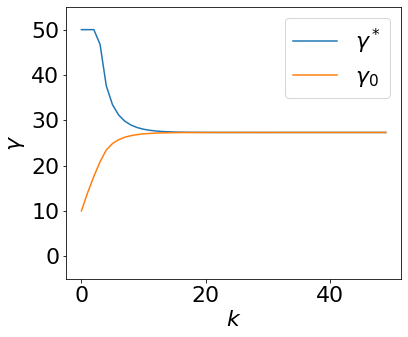

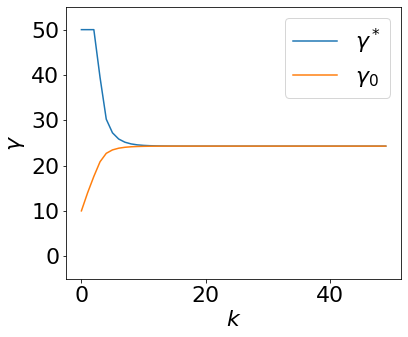

In [428]:
for i in range(2):
    plt.figure(figsize=(6,5))
    plt.ylim([-5,55])
    plt.xlabel(r'$k$')
    plt.ylabel(r'$\gamma$')
    plt.plot([gammaStar[i] for gammaStar in gammaStars_save*180./np.pi], label=r'$\gamma^*$')
    plt.plot([gamma0[i] for gamma0 in gamma0s_save*180./np.pi], label=r'$\gamma_0$')
    plt.legend()
    plt.savefig('iter_relaxed', bbox_inches='tight')
    plt.show()

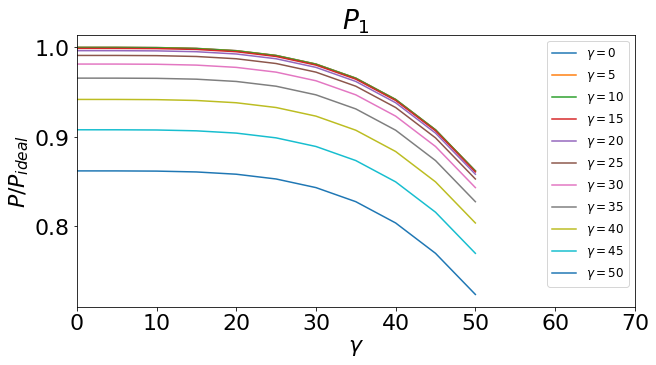

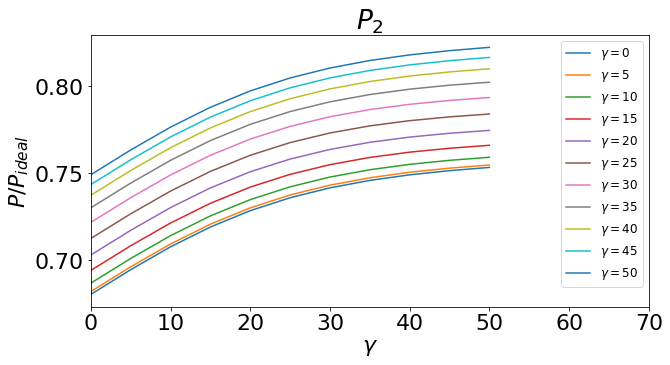

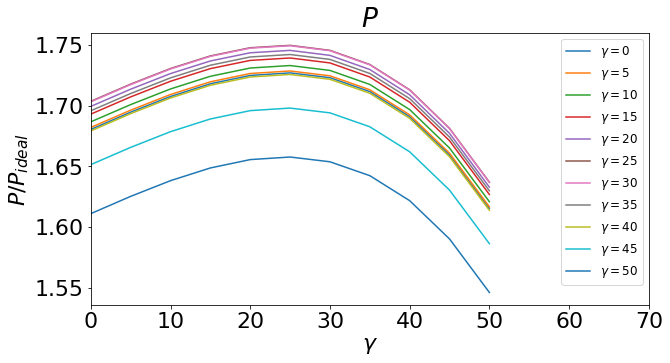

In [466]:
# grid search for comparison
gammas = np.linspace(0,50,11)*np.pi/180.
P1s = []
P2s = []
Ps = []
for gamma1 in gammas:
    for gamma2 in gammas:
        P1 = .5*rho*A*Cp*U_inf**3*np.cos(gamma1**2) + .5*rho*A*Cp*U_inf**3*np.cos(gamma2**2)
        P2 = get_P2(np.array([gamma1,gamma2]), x0s, y0s, xs, ys)
        P = P1 + P2
        
        P1s.append(P1)
        P2s.append(P2)
        Ps.append(P)
        
plt.figure(1, figsize=(10,5))
plt.figure(2, figsize=(10,5))
plt.figure(3, figsize=(10,5))

labels = [r'$\gamma=$%.0f'%(gamma*180./np.pi) for gamma in gammas]
M = len(gammas)
for i in range(M):
    plt.figure(1)
    plt.plot(gammas*180./np.pi, P1s[i*M:(i+1)*M]/(P_ideal/2.), label=labels[i])
    plt.figure(2)
    plt.plot(gammas*180./np.pi, P2s[i*M:(i+1)*M]/(P_ideal/2.), label=labels[i])
    plt.figure(3)
    plt.plot(gammas*180./np.pi, Ps[i*M:(i+1)*M]/(P_ideal/2.), label=labels[i])
#     plt.scatter(gammas[np.argmax(Ps)]*180./np.pi, np.max(Ps)/(P_ideal/2.), color='tab:green', marker="*", s=100, label=r'true max $P$')
titles=[r'$P_1$', r'$P_2$', r'$P$']
for i in range(3):
    plt.figure(i+1)
    plt.title(titles[i])
    plt.legend(loc='upper right', prop={'size': 12})
    plt.xlabel(r'$\gamma$')
    plt.ylabel(r'$P/P_{ideal}$')
    plt.xlim([0, 70])
    #plt.savefig('power', bbox_inches='tight')
plt.show()

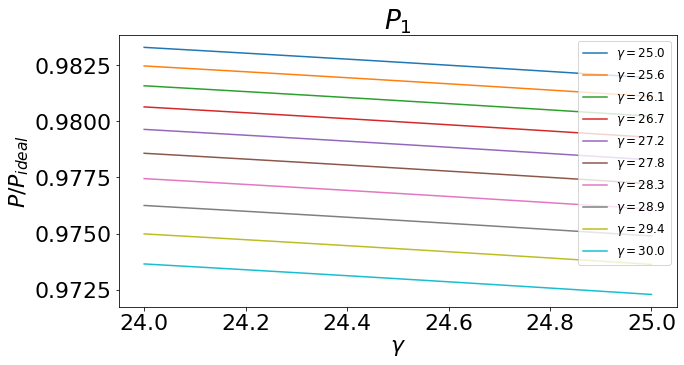

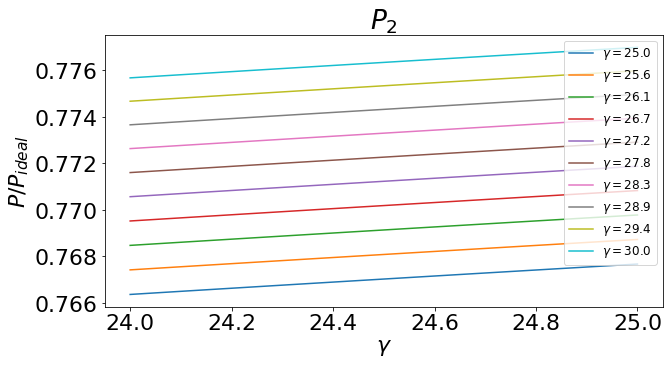

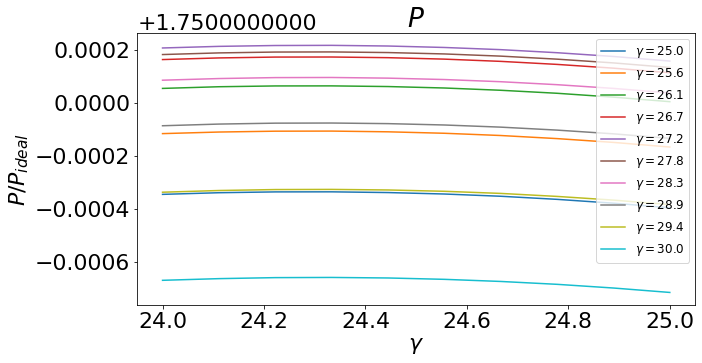

In [487]:
# grid search for comparison
gamma1s = np.linspace(25,30,10)*np.pi/180.
gamma2s = np.linspace(24,25,10)*np.pi/180.
P1s = []
P2s = []
Ps = []
for gamma1 in gamma1s:
    for gamma2 in gamma2s:
        P1 = .5*rho*A*Cp*U_inf**3*np.cos(gamma1**2) + .5*rho*A*Cp*U_inf**3*np.cos(gamma2**2)
        P2 = get_P2(np.array([gamma1,gamma2]), x0s, y0s, xs, ys)
        P = P1 + P2
        
        P1s.append(P1)
        P2s.append(P2)
        Ps.append(P)
        
plt.figure(1, figsize=(10,5))
plt.figure(2, figsize=(10,5))
plt.figure(3, figsize=(10,5))

labels = [r'$\gamma=$%.1f'%(gamma*180./np.pi) for gamma in gamma1s]
M = len(gammas)
for i in range(M):
    plt.figure(1)
    plt.plot(gamma2s*180./np.pi, P1s[i*M:(i+1)*M]/(P_ideal/2.), label=labels[i])
    plt.figure(2)
    plt.plot(gamma2s*180./np.pi, P2s[i*M:(i+1)*M]/(P_ideal/2.), label=labels[i])
    plt.figure(3)
    plt.plot(gamma2s*180./np.pi, Ps[i*M:(i+1)*M]/(P_ideal/2.), label=labels[i])
#     plt.scatter(gammas[np.argmax(Ps)]*180./np.pi, np.max(Ps)/(P_ideal/2.), color='tab:green', marker="*", s=100, label=r'true max $P$')
titles=[r'$P_1$', r'$P_2$', r'$P$']
for i in range(3):
    plt.figure(i+1)
    plt.title(titles[i])
    plt.legend(loc='upper right', prop={'size': 12})
    plt.xlabel(r'$\gamma$')
    plt.ylabel(r'$P/P_{ideal}$')
#     plt.xlim([23, 28])
    #plt.savefig('power', bbox_inches='tight')
plt.show()

In [500]:
# tuned by hand
np.round([gamma1s[np.argmax(Ps)//M]*180./np.pi, gamma2s[np.argmax(Ps)%M]*180./np.pi])

array([27., 24.])

In [506]:
# optimized
np.round(gammaStars_save[-1,:]*180./np.pi)

array([27., 24.])

In [520]:
ys

[-178.3, 178.3]

In [530]:
def get_u(x,y, gamma, x0, y0):
    sigma_z0 = np.sqrt(1./8.)*D 
    sigma_y0 = sigma_z0*np.cos(gamma)

    theta = .3*gamma/np.cos(gamma)*(1-np.sqrt(1-Ct*np.cos(gamma)))
    delta0 = (x-x0)*theta # Annoni wrong -> see Bastankhah (7.4)
    sigma_y = ky*(x-x0)+sigma_y0
    delta_log = np.log(((1.6+np.sqrt(M0))*(1.6*np.sqrt(sigma_y/sigma_y0)-np.sqrt(M0))) / 
                       ((1.6-np.sqrt(M0))*(1.6*np.sqrt(sigma_y/sigma_y0)+np.sqrt(M0))))
    delta = y0 + delta0 + D*theta*E0/5.2*np.sqrt(sigma_y0/(ky*M0))*delta_log

    C = 1. - np.sqrt(1. - sigma_y0*M0/sigma_y)
    
    return U_inf*(1.-C*np.exp(-.5*((y-delta)/sigma_y)**2))

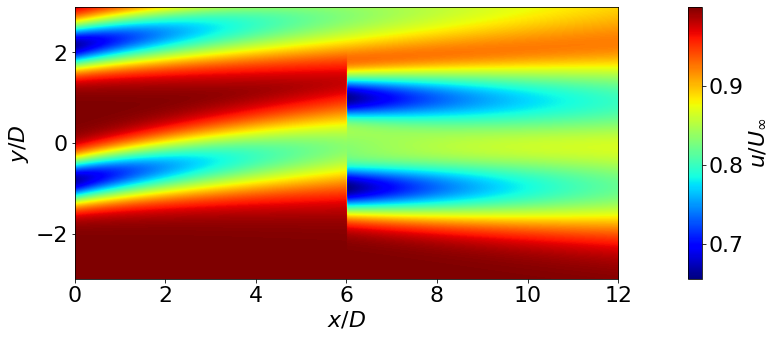

In [543]:
N = 1000
y_min = -3.*D
y_max = 3.*D
y = np.linspace(y_min, y_max, N)
Us_row1 = []
Us_row2 = []

# row 1
x0 = -1.*D # [1] 1.088
y0s = [-1.*D, 2.*D]
x_min = x0+1.*D
x_max = 12*D
x = np.linspace(x_min, x_max, N)
X, Y = np.meshgrid(x, y)
Us_row1 = []
for j in range(len(y0s)):
    y0 = y0s[j]
    gamma = gammaStars_save[-1][j]
    U = np.zeros((N,N))
    for i in range(N):
        xi = x[i]
        U[i,:] = get_u(xi, y, gamma, x0, y0)
    Us_row1.append(U)
    
# row 2
x0 = 5.*D
y0s = [-1.*D, 1.*D]
x_min = x0+1.*D
x_max = 12*D
x = np.linspace(x_min, x_max, int(N/2))
X, Y = np.meshgrid(x, y)
for j in range(len(y0s)):
    y0 = y0s[j]
    gamma = gammaStars_save[-1][j]
    # no yaw for last row, which is row 2 rn
    gamma = 0.
    U = np.zeros((int(N/2),N))
    for i in range(int(N/2)):
        xi = x[i]
        U[i,:] = get_u(xi, y, gamma, x0, y0)
    Us_row2.append(U)
    
x0 = 0.*D
x_min = x0
x_max = 12*D
x = np.linspace(x_min, x_max, N)
N2 = int(N/2)

U_tot = np.zeros((N,N))
for j in range(len(y0s)):
    U1 = Us_row1[j]
    U2 = Us_row2[j] #no yaw for row 2
    U_tot += (1.-U1/U_inf)**2
    U_tot[N2:,:] += (1.-U2/U_inf)**2
U_tot = U_inf*(1.-np.sqrt(U_tot))

plt.rcParams["figure.figsize"] = (25,5)
plt.rcParams.update({'font.size': 22})

plt.imshow(U_tot.T/U_inf, extent=[x_min/D, x_max/D, y_max/D, y_min/D], cmap='jet')
ax=plt.gca()
ax.invert_yaxis()
plt.xlabel(r'$x/D$')
plt.ylabel(r'$y/D$')
cbar = plt.colorbar()
cbar.set_label(r'$u/U_{\infty}$')
# plt.title(r'$u(x,y)$ with $\gamma=%d^{\circ}$'%np.round(gamma))
# plt.savefig('flowField_fourTurbines_gamma%d'%np.round(gamma), bbox_inches='tight')
plt.show()